# HCP HMM Analysis

Here we train an HMM on preprocessed fMRI data from HCP. We study the ICA parcellated node time series provided in the public dataset:
```
HCP1200 Parcellation+Timeseries+Netmats (PTN)
1003 Subjects, recon r177 + r227, PTN Release (13GB)
```

## Load data

First let's load the ICA data and prepare (standardize) it for the HMM.

In [1]:
from glob import glob
from osl_dynamics.data import Data

files = sorted(glob("node_timeseries/3T_HCP1200_MSMAll_d25_ts2/*.txt"))
data = Data(files, use_tfrecord=True, n_jobs=4)
data = data.standardize()

print(data)

QUEUEING TASKS | Loading files:   0%|          | 0/1003 [00:00<?, ?it/s]

PROCESSING TASKS | Loading files:   0%|          | 0/1003 [00:00<?, ?it/s]

COLLECTING RESULTS | Loading files:   0%|          | 0/1003 [00:00<?, ?it/s]

QUEUEING TASKS | Standardize:   0%|          | 0/1003 [00:00<?, ?it/s]

PROCESSING TASKS | Standardize:   0%|          | 0/1003 [00:00<?, ?it/s]

COLLECTING RESULTS | Standardize:   0%|          | 0/1003 [00:00<?, ?it/s]

Data
 id: 5345248848
 n_sessions: 1003
 n_samples: 4814400
 n_channels: 25


## Train the HMM

First build the model:

In [2]:
from osl_dynamics.models.hmm import Config, Model

config = Config(
    n_states=10,
    n_channels=data.n_channels,
    sequence_length=100,
    learn_means=True,
    learn_covariances=True,
    batch_size=512,
    learning_rate=0.01,
    n_epochs=20,
)
model = Model(config)
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 100, 25)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (10, 25)          │        250 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (10, 25, 25)      │      3,250 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 100, 25)   │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 100, 25)   │          0 │ ll[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 100, 25), │        110 │ cast[0][0]        │
│ (HiddenMarkovState… │ (None, 100, 10,   │            │                   │
│                     │ 10)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 100, 25)   │          0 │ hid_state_inf[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ cast_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,610 (14.10 KB)

 Trainable params: 3,610 (14.10 KB)

 Non-trainable params: 0 (0.00 B)

And train on the prepared data:

In [3]:
# Initialization (find good initial values for model parameters to start the full training from)
init_history = model.random_state_time_course_initialization(data, n_init=3, n_epochs=1)

# Full training
history = model.fit(data)

# Save
results_dir = "results"
model_dir = f"{results_dir}/model"
model.save(model_dir)

2025-05-17 16:20:18 INFO osl-dynamics [inf_mod_base.py:1376:random_state_time_course_initialization]: Random state time course initialization
2025-05-17 16:20:18 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl
2025-05-17 16:20:18 WARNING osl-dynamics [base.py:1722:_check_rewrite]: Identifier has changed. Rewriting TFRecords.


QUEUEING TASKS | Creating TFRecord datasets:   0%|          | 0/1003 [00:00<?, ?it/s]

PROCESSING TASKS | Creating TFRecord datasets:   0%|          | 0/1003 [00:00<?, ?it/s]

2025-05-17 16:20:18.215668: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.216086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.217443: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.228482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.251500: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.296371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-17 16:20:18.383608: I tensorflow/core/framework/local_rendezvous.cc:407] L

COLLECTING RESULTS | Creating TFRecord datasets:   0%|          | 0/1003 [00:00<?, ?it/s]

2025-05-17 16:20:20 INFO osl-dynamics [misc.py:383:save]: Saving tmp/tfrecord_config.pkl
2025-05-17 16:20:20 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl
2025-05-17 16:20:20 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 0
2025-05-17 16:20:20 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances
2025-05-17 16:20:20.956595: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 326ms/step - ll_loss: 30.0867 - loss: 30.0867 - learning_rate: 0.0100 - rho: 0.2853


/Users/cgoh0451/packages/anaconda3/envs/osld/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-17 16:21:00 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 1
2025-05-17 16:21:00 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances


94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 331ms/step - ll_loss: 30.1103 - loss: 30.1103 - learning_rate: 0.0100 - rho: 0.2853


2025-05-17 16:21:39 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 2
2025-05-17 16:21:39 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - ll_loss: 30.1306 - loss: 30.1306 - learning_rate: 0.0100 - rho: 0.2853


2025-05-17 16:22:20 INFO osl-dynamics [inf_mod_base.py:1421:random_state_time_course_initialization]: Using initialization 1
2025-05-17 16:22:20 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl
2025-05-17 16:22:20 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 356ms/step - ll_loss: 29.2826 - loss: 29.2826 - learning_rate: 0.0100 - rho: 0.2853
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - ll_loss: 29.2315 - loss: 29.2315 - learning_rate: 0.0090 - rho: 0.1866
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step - ll_loss: 29.2020 - loss: 29.2020 - learning_rate: 0.0082 - rho: 0.1436
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 493ms/step - ll_loss: 29.1660 - loss: 29.1659 - learning_rate: 0.0074 - rho: 0.1187
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 469ms/step - ll_loss: 29.1681 - loss: 29.1681 - learning_rate: 0.0067 - rho: 0.1022
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - ll_loss: 29.1521 - loss: 29.1521 - learning_rate: 0.0061 - rho: 0.0904
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - ll_loss: 29.1697 - loss: 29.1698 - learning_rate: 0.0055 - rho: 0.0814
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - ll_loss: 29.1608 - loss: 29.1608 - learning_rate: 0.0050 - rho:

2025-05-17 16:33:10.803167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - ll_loss: 29.1629 - loss: 29.1629 - learning_rate: 0.0022 - rho: 0.0461
Epoch 17/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - ll_loss: 29.1544 - loss: 29.1544 - learning_rate: 0.0020 - rho: 0.0442
Epoch 18/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - ll_loss: 29.1457 - loss: 29.1457 - learning_rate: 0.0018 - rho: 0.0425
Epoch 19/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 446ms/step - ll_loss: 29.1401 - loss: 29.1401 - learning_rate: 0.0017 - rho: 0.0410
Epoch 20/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 447ms/step - ll_loss: 29.1583 - loss: 29.1583 - learning_rate: 0.0015 - rho: 0.0395


Let's calculate the _variational free energy_ of the training model. This is a metric that can be used for model comparison. Normally, we would train the HMM multiple times and pick the one with the lowest variational free energy for subsequent analysis.

In [4]:
import pickle

# Calculate the variational free energy
free_energy = model.free_energy(data)
history["free_energy"] = free_energy

# Save training history and free energy
pickle.dump(init_history, open(f"{model_dir}/init_history.pkl", "wb"))
pickle.dump(history, open(f"{model_dir}/history.pkl", "wb"))

2025-05-17 16:36:44 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl
2025-05-17 16:36:44 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl


Getting free energy: 0it [00:00, ?it/s]

## Post-hoc Analysis

Now we have trained the HMM, let's estimate subject-specific HMM network features - this is known as _dual estimation_.

### Summary statistics for dynamics

The HMM provides the probability for each state being active for each time point for each subject (known as the _posterior_ in Bayesian inference). Let's calculate this for each subject.

In [5]:
import os

# Inferred state probabilities
alp = model.get_alpha(data)

# Save
inf_params_dir = f"{results_dir}/inf_params"
os.makedirs(inf_params_dir, exist_ok=True)
pickle.dump(alp, open(f"{inf_params_dir}/alp.pkl", "wb"))

2025-05-17 16:37:08 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl
2025-05-17 16:37:08 INFO osl-dynamics [misc.py:409:load]: Loading tmp/tfrecord_config.pkl


Getting alpha:   0%|          | 0/1003 [00:00<?, ?it/s]

Next, we hard classify the probabilities and calculate summary statistics for dynamics.

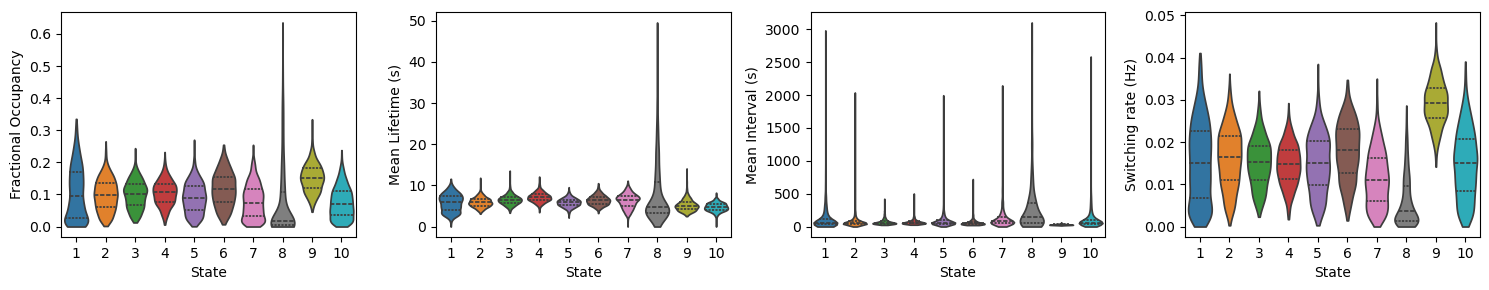

In [6]:
import numpy as np
from osl_dynamics.inference import modes
from osl_dynamics.utils import plotting

# State time course
stc = modes.argmax_time_courses(alp)

# Calculate summary statistics
fs = 1 / 0.72
fo = modes.fractional_occupancies(stc)
lt = modes.mean_lifetimes(stc, sampling_frequency=fs)
intv = modes.mean_intervals(stc, sampling_frequency=fs)
sr = modes.switching_rates(stc, sampling_frequency=fs)

# Save
summary_stats_dir = f"{results_dir}/summary_stats"
os.makedirs(summary_stats_dir, exist_ok=True)
np.save(f"{summary_stats_dir}/fo.npy", fo)
np.save(f"{summary_stats_dir}/lt.npy", lt)
np.save(f"{summary_stats_dir}/intv.npy", intv)
np.save(f"{summary_stats_dir}/sr.npy", sr)

# Plot
fig, ax = plotting.plot_hmm_summary_stats(fo, lt, intv, sr)

Focusing on the fractional occupancies (FOs), we can cluster the FO for each state across subjects to reproduce the FO correlation analysis performed in [Vidaurre 2017](https://www.pnas.org/doi/abs/10.1073/pnas.1705120114).

Text(0, 0.5, 'State')

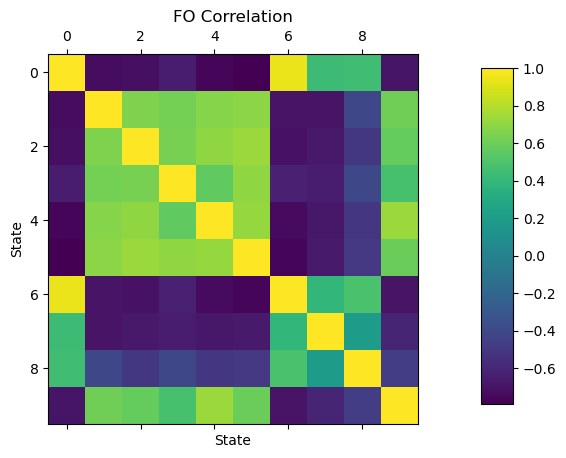

In [7]:
fo_corr = np.corrcoef(fo.T)
fo_corr.shape

fig, ax = plotting.plot_matrices(fo_corr)
ax[0,0].set_title("FO Correlation")
ax[0,0].set_xlabel("State")
ax[0,0].set_ylabel("State")

We can also look at the transition probabilities between states. Let's look at the group level transition probability matrix.

Text(0, 0.5, 'State (From)')

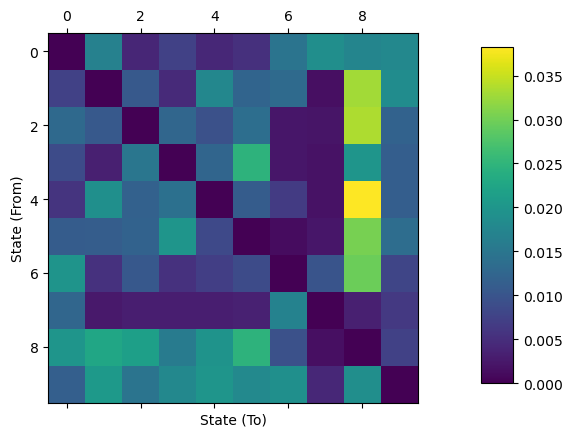

In [8]:
trans_prob = model.get_trans_prob()

# Fill diagonal with zeros so we can see the off-diagonal elements
np.fill_diagonal(trans_prob, 0)

fig, ax = plotting.plot_matrices(trans_prob)
ax[0,0].set_xlabel('State (To)')
ax[0,0].set_ylabel('State (From)')

### State networks (observation model parameters)

The HMM also learns the group-average mean and covariance for each state. Let's get the learn group-level state means and covariances.

In [9]:
# Observation model parameters
means, covs = model.get_means_covariances()
print('means.shape =', means.shape)
print('covs.shape =', covs.shape)

# Save
np.save(f"{inf_params_dir}/means.npy", means)
np.save(f"{inf_params_dir}/covs.npy", covs)

means.shape = (10, 25)
covs.shape = (10, 25, 25)


These means and covariances correspond to the mean/covariance of the ICA time courses. We can use the spatial maps (ICA parcellation) to project the state mean vectors to the brain surface:

In [10]:
from osl_dynamics.analysis import power

# Spatial maps from ICA applied to the fMRI data
ica_spatial_maps = "groupICA/groupICA_3T_HCP1200_MSMAll_d25.ica/melodic_IC.dscalar.nii"

# Save cifti containing the state maps
surf_map = power.independent_components_to_surface_maps(
    ica_spatial_maps=ica_spatial_maps,
    ic_values=means,
    output_file=f"{inf_params_dir}/means.dscalar.nii",
)

2025-05-17 16:37:36 INFO osl-dynamics [power.py:698:independent_components_to_surface_maps]: Saving results/inf_params/means.dscalar.nii


Let's plot the surface maps for the group-level state means.

In [11]:
from osl_dynamics.analysis import workbench
from IPython.display import display, HTML

# Setup workbench (you may not need to do this)
workbench.setup("/Users/cgoh0451/packages/workbench/bin_macosxub")

# Plot
workbench.render(
    img=f"{inf_params_dir}/means.dscalar.nii",
    gui=False,
    save_dir="tmp",
    image_name="plots/means_.png",
    input_is_cifti=True,
)

# Show
images = [(f'State {i+1}', f'plots/means_{i:02d}.png') for i in range(config.n_states)]
html = '<div style="display: flex; flex-direction: row; align-items: flex-start;">'
for title, img in images:
    html += f'''
    <div style="margin-right: 20px; text-align: center;">
        <div style="font-weight: bold; margin-bottom: 5px;">{title}</div>
        <img src="{img}" style="width: 300px;" />
    </div>
    '''
html += '</div>'
display(HTML(html))

Saving images:   0%|          | 0/10 [00:00<?, ?it/s]

### Dual estimation

We can use dual estimation to calculate subject-specific state means and covariances:

In [12]:
means, covs = model.dual_estimation(data, alp)
print('means.shape =', means.shape)
print('covs.shape =', covs.shape)

# Save
dual_estimates_dir = f"{results_dir}/dual_estimates"
os.makedirs(dual_estimates_dir, exist_ok=True)
np.save(f"{dual_estimates_dir}/means.npy", means)
np.save(f"{dual_estimates_dir}/covs.npy", covs)

Dual estimation:   0%|          | 0/1003 [00:00<?, ?it/s]

means.shape = (1003, 10, 25)
covs.shape = (1003, 10, 25, 25)


We see now we have subject and state-specific means and covariances.

Similar, we can dual estimate the transition probabilities for each subject.

In [13]:
from osl_dynamics.analysis import modes

trans_prob = modes.calc_trans_prob_matrix(stc)
print(trans_prob.shape)

np.save(f"{dual_estimates_dir}/trans_prob.npy", trans_prob)

(1003, 10, 10)


### Clean up temporary files

We created a `tmp` directory to store files in this script, we can safely delete this now.

In [14]:
os.system("rm -r tmp")

0